In [5]:
%load_ext autoreload
%autoreload 2

In [98]:
folder = '/home/olga/data_sm/kmer-hashing/classify_coding_vs_noncoding/'

In [96]:
! cd $folder

In [97]:
import gzip
import itertools
import random
import requests

from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from khtools.ensembl import get_sequence, maybe_get_cds
from khtools.compare_peptide import kmerize, jaccardize

In [15]:
len(get_sequence('ENST00000307377', type='cdna'))

2018

In [16]:
len(get_sequence('ENST00000307377', type='cds'))

1641

In [17]:
GENCODE_FOLDER = '/home/olga/data_lg/czbiohub-reference/gencode/'
! ls -lha $GENCODE_FOLDER

total 2.0K
drwxrwxr-x  4 olga 21002 4.0K Jul 16 10:06 .
drwxrwxr-x 14 olga 21002 4.0K Sep  4 16:14 ..
drwxrwxr-x  4 olga 21002 4.0K Jul 16 10:06 human
drwxrwxr-x  5 olga 21002 4.0K Jul 16 10:06 mouse


In [18]:
ls $GENCODE_FOLDER/human/v30/

gencode.v30.annotation.ERCC92.bed
gencode.v30.annotation.ERCC92.gene_type.bed
gencode.v30.annotation.ERCC92.gene_type.gtf*
gencode.v30.annotation.ERCC92.gtf*
gencode.v30.annotation.gtf*
gencode.v30.pc_translations.fa.gz
gencode.v30.transcripts.ERCC92.fa*
gencode.v30.transcripts.fa*
getfasta_transcript_test.fa*
GRCh38.p12.genome.ERCC92.fa*
GRCh38.p12.genome.fa*
GRCh38.p12.genome.fa.fai*
Homo_sapiens.GRCh38.96.bed
Makefile*
Makefile~*
salmon_index/
STARIndex/
test_gffread_transcripts.fa*
test_gffread_transcripts_no_dashF.fa*
w*


In [19]:
! grep '>' $GENCODE_FOLDER/human/v30/gencode.v30.transcripts.fa | cut -f 8 -d '|' | sort | uniq -c

     41 3prime_overlapping_ncRNA
  11636 antisense
    329 bidirectional_promoter_lncRNA
     23 IG_C_gene
      9 IG_C_pseudogene
     37 IG_D_gene
     18 IG_J_gene
      3 IG_J_pseudogene
      1 IG_pseudogene
    144 IG_V_gene
    188 IG_V_pseudogene
  14933 lincRNA
      1 macro_lncRNA
   1881 miRNA
   2227 misc_RNA
      2 Mt_rRNA
     22 Mt_tRNA
      1 non_coding
  15550 nonsense_mediated_decay
     90 non_stop_decay
     63 polymorphic_pseudogene
  10171 processed_pseudogene
  28809 processed_transcript
  83688 protein_coding
     38 pseudogene
  28273 retained_intron
      8 ribozyme
     52 rRNA
    500 rRNA_pseudogene
     49 scaRNA
      1 scRNA
    950 sense_intronic
    368 sense_overlapping
    954 snoRNA
   1901 snRNA
      5 sRNA
   1158 TEC
    494 transcribed_processed_pseudogene
    131 transcribed_unitary_pseudogene
    914 transcribed_unprocessed_pseudogene
      2 translated_processed_pseudogene
      6 TR_C_gene
      4 TR_D_gene
     79 TR_J_gene
      4 TR_J_

In [81]:
%%time

n_desired_records = 1000

random.seed(0)

lincRNA = []
protein_coding = []

lincRNA_metadata_lines = []
protein_coding_metadata_lines = []

records = list(SeqIO.parse(f"{GENCODE_FOLDER}/human/v30/gencode.v30.transcripts.fa", 'fasta'))

# Shuffles in-place and returns none
random.shuffle(records)

for record in records:
    metadata = record.name.strip('|').split("|")
    if metadata[-1] == 'protein_coding':
        if len(protein_coding) < n_desired_records:
            protein_coding.append((metadata[0].split(".")[0], str(record.seq)))
            protein_coding_metadata_lines.append(metadata)
    elif metadata[-1] == 'lincRNA':
        if len(lincRNA) < n_desired_records:
            lincRNA.append((metadata[0].split(".")[0], str(record.seq)))
            lincRNA_metadata_lines.append(metadata)
    if len(lincRNA) >= n_desired_records and len(protein_coding) >= n_desired_records:
        break
# del records

CPU times: user 11.1 s, sys: 744 ms, total: 11.8 s
Wall time: 11.8 s


In [82]:
lncrna_df = pd.DataFrame(lincRNA_metadata_lines)
print(lncrna_df.shape)
lncrna_df.head()

(1000, 8)


,0,1,2,3,4,5,6,7
0,ENST00000623420.1,ENSG00000279927.1,OTTHUMG00000189181.1,OTTHUMT00000479003.1,Z95114.4-201,Z95114.4,3578,lincRNA
1,ENST00000628547.2,ENSG00000242086.8,OTTHUMG00000155834.14,OTTHUMT00000481409.1,MUC20-OT1-308,MUC20-OT1,882,lincRNA
2,ENST00000411525.1,ENSG00000224429.7,OTTHUMG00000016541.3,OTTHUMT00000044126.1,LINC00539-201,LINC00539,664,lincRNA
3,ENST00000427111.4,ENSG00000237248.5,OTTHUMG00000168333.2,OTTHUMT00000500908.1,LINC00987-201,LINC00987,2472,lincRNA
4,ENST00000551227.1,ENSG00000258028.2,OTTHUMG00000170370.2,OTTHUMT00000408712.1,AL135878.1-201,AL135878.1,741,lincRNA


In [83]:
protein_coding_df = pd.DataFrame(protein_coding_metadata_lines)
print(protein_coding_df.shape)
protein_coding_df.head()

(1000, 8)


,0,1,2,3,4,5,6,7
0,ENST00000525764.5,ENSG00000149150.9,OTTHUMG00000167030.4,OTTHUMT00000392591.2,SLC43A1-203,SLC43A1,556,protein_coding
1,ENST00000576452.5,ENSG00000108523.15,OTTHUMG00000099397.5,OTTHUMT00000438729.1,RNF167-215,RNF167,589,protein_coding
2,ENST00000307377.12,ENSG00000170266.16,OTTHUMG00000155781.8,OTTHUMT00000341571.1,GLB1-202,GLB1,2018,protein_coding
3,ENST00000649592.1,ENSG00000114861.20,OTTHUMG00000158803.17,OTTHUMT00000497729.1,FOXP1-260,FOXP1,1975,protein_coding
4,ENST00000454061.5,ENSG00000214413.8,OTTHUMG00000019046.6,OTTHUMT00000050350.2,BBIP1-208,BBIP1,812,protein_coding


In [84]:
lincRNA[:2]

[('ENST00000623420',
  'GCCCTGCCAGCCACTGTTCTAAGCACTTTTTCCCTGTTCCTGCCGATTTGCTCCTCACAACAACCATAGGAAGTGGAGACTATGATTATCCCCGTTGCACAGTAAGGAAACTGAGGCAAAAGGCGGTTAGGTAACTTGGCGATGTCTCCCGGCTAGGGATAGCAGAATGGGATAGAAACGCAGGCCACGCGGTCTGGAGCGGTGGCTCACGCCTTTAATCCCAGTACTTAGGGAGGCCGAGGCGGGCGGGTTACCTGGGGTCAGGAGTTCGAGACCAGCCTGGCCAACATGGTGAAACCCTATCTCTACTAAAAATACAAAAATTAGTCGGGGTGGGCACCTGTAATCCCAGCTACTCGAGGCTGAGGCAAAAGAATCGCTTGAACCCAGGAGGCAGAGGTGGCAGTGAGCCGAGATCACCCCACTGCACTTCAGCCTGGGTGGCAGAACAAGACTCTGTCTCAAAAAAAAAAAAAAGAATAAAAAAAAGAAAGGCAGGCCACCCGGTGGTGGTCCCTGTGCTCCTCCCCACCCACCCCCGCACTGTGCTGGGCGGTGAGGAGGCGGCTGGCCCAGGAGGTGGGGGTGTGGAGTGGGGCACATCAGAGATTTCAAATTGACCAAGGTCTGTTTTGTGTCAGTTTGTCAGTTTTATGTGTCAGCTTGGCTAAACTATGGTCTCCTGTTATTTGATCAAACACTAATCTATTTTTTCTTTTAGTTTAAAAAATAATAATTAAATGAAAAAATCCTGGCTAATGTTTTTTTTTTTGTAGAGACAGGGTTTTGCCTTGTTGCCCAGGCTGGCCTCTGACCCTTGGGCTCAAGTGATCTGCCACCATGCCTAGCCTCAAACACTAATCTAGATGTTGCTTGAAGGCATTTTGTAGATGTGATTTGTCTATAATTAGTTTACTTCAAGTAAGGGAGATTATCCCAGATAATCTGGGTGAGTCTGAAAGACTTTATGGGTAGA

In [85]:
protein_coding[:2]

[('ENST00000525764',
  'CACCAACACCACCCAGGATGAGCAGCGCAGGTGGCCAGGCTGTGACCAGCAGGACGAGATGCTCAACCTGGGCTTCACCATTGGTTCCTTCGTGCTCAGCGCCACCACCCTGCCACTGGGGATCCTCATGGACCGCTTTGGCCCCCGACCCGTGCGGCTGGTTGGCAGTGCCTGCTTCACTGCGTCCTGCACCCTCATGGCCCTGGCCTCCCGGGACGTGGAAGCTCTGTCTCCGTTGATATTCCTGGCGCTGTCCCTGAATGGCTTTGGTGGCATCTGCCTAACGTTCACTTCACTCACGGGACGGGGTTGCTACCAAATCCATCAGACCACGCTACTGCAAGATCCAAAAGCTCACCAATGCCATCAGTGCCTTCACCCTGACCAACCTGCTGCTTGTGGGTTTTGGCATCACCTGTCTCATCAACAACTTACACCTCCAGTTTGTGACCTTTGTCCTGCACACCATTGTTCGAGGTTTCTTCCACTCAGCCTGTGGGAGTCTCTATGCTGCAGTGTTCCCATCCAACCACTTTGGGACGCTGACAGGCCTGCA'),
 ('ENST00000576452',
  'AGGAGGAGCTTGATGGAAGCGTGCGAGAAGGGGCGTAACTGATTTGGAAACCAGAGGAAAGGCGCTGTTTTCACCGAATTAGAATCGCGGGAAAATAGAGAAGAGTTTGTTTGAAGGTCTCGCGAGATCGAGTGAGTACGGCTCGCCAAGTTGGAGCGCTCTCGCGATAGACACAGCAACTATTCAGCTGCGAGGGGACGGGAGAGGTGGTGAGCACTCTCGCGAGATTTGAAGGAGCGGCGGAGGCCAGAGGGAGGAGAGGACGCGCGGCCTCCTCAGCCTCTTTCCTCCCGCTGCCATGCACCCTGCAGCCTTCCCGCTTCCTGTGGTTGTGGCCGCTGTGCTGTGGGGAGCGGCCCCGACCCGGGGGCTCATTCGAGCGACCTCGGACC

In [86]:
ksize = 7
print(f"total possible k-mers of size {ksize}", 4**ksize)

lincrna_kmers = set(itertools.chain(*[kmerize(seq, ksize) for transcript_id, seq in lincRNA]))
print(len(lincrna_kmers))

total possible k-mers of size 7 16384
16371


In [87]:
protein_coding_cdna_kmers = set(itertools.chain(*[kmerize(seq, ksize) for transcript_id, seq in protein_coding if seq is not None]))
print(len(protein_coding_cdna_kmers))

16384


In [88]:
jaccardize(protein_coding_cdna_kmers, lincrna_kmers)

1.0

In [89]:
%%time

protein_coding_cds_only = [(transcript_id, maybe_get_cds(transcript_id)) for transcript_id, seq in protein_coding]
len(protein_coding_cds_only)


TypeError: get_sequence() got an unexpected keyword argument 'type'

In [90]:
protein_coding_cds_only[:2]

[('ENST00000525764',
  'NNCACCAACACCACCCAGGATGAGCAGCGCAGGTGGCCAGGCTGTGACCAGCAGGACGAGATGCTCAACCTGGGCTTCACCATTGGTTCCTTCGTGCTCAGCGCCACCACCCTGCCACTGGGGATCCTCATGGACCGCTTTGGCCCCCGACCCGTGCGGCTGGTTGGCAGTGCCTGCTTCACTGCGTCCTGCACCCTCATGGCCCTGGCCTCCCGGGACGTGGAAGCTCTGTCTCCGTTGATATTCCTGGCGCTGTCCCTGAATGGCTTTGGTGGCATCTGCCTAACGTTCACTTCACTCACGGGACGGGGTTGCTACCAAATCCATCAGACCACGCTACTGCAAGATCCAAAAGCTCACCAATGCCATCAGTGCCTTCACCCTGACCAACCTGCTGCTTGTGGGTTTTGGCATCACCTGTCTCATCAACAACTTACACCTCCAGTTTGTGACCTTTGTCCTGCACACCATTGTTCGAGGTTTCTTCCACTCAGCCTGTGGGAGTCTCTATGCTGCAGTGTTCCCATCCAACCACTTTGGGACGCTGACAGGCCTGCA'),
 ('ENST00000576452',
  'ATGCACCCTGCAGCCTTCCCGCTTCCTGTGGTTGTGGCCGCTGTGCTGTGGGGAGCGGCCCCGACCCGGGGGCTCATTCGAGCGACCTCGGACCACAATGCCAGCATGGACTTTGCAGACCTTCCAGCTCTGTTTGGGGCTACCTTGAGCCAGGAGGGCCTCCAGGGGTTCCTTGTGGAGGCTCACCCAGACAATGCCTGCAGCCCCATTGCCCCACCACCCCCAGCCCCGGTCAATGGGTCAGTCTTTATTGCGCTGCTTCGAAGATTCGACTGCAACTTTGACCTCAAG')]

In [91]:
ksize = 7

In [92]:

protein_coding_kmers = set(itertools.chain(*[kmerize(seq, ksize) for transcript_id, seq in protein_coding_cds_only if seq is not None]))
print(len(protein_coding_kmers))

16399


In [93]:
jaccardize(protein_coding_kmers, lincrna_kmers)

0.998533993036467

In [94]:
%%time

ksizes = range(5, 22)

lines = []
n_kmer_lines = []

def kmerize_count_append(id_seqs, name):
    kmers = set(itertools.chain(*[kmerize(seq, ksize) for transcript_id, seq in id_seqs if seq is not None]))
    n_kmers = len(kmers)
    
    n_kmer_lines.append([ksize, len(kmers), name])
    return kmers, n_kmer_lines

for ksize in ksizes:
    n_possible_kmers = 4**ksize
    n_kmer_lines.append([ksize, n_possible_kmers, 'total possible: 4^k'])
    
    print(f"total possible k-mers of size {ksize}: ", n_possible_kmers)
    
    # lincRNAs
    lincrna_kmers, n_kmer_lines = kmerize_count_append(lincRNA, 'lincRNA')
    
    # Protein-coding CDNA (whole transcript)
    protein_coding_cdna_kmers, n_kmer_lines = kmerize_count_append(protein_coding, 'protein_coding_cdna')
    
    # Protein-coding CDS (translated part only)
    protein_coding_cds_kmers, n_kmer_lines = kmerize_count_append(protein_coding_cds_only, 'protein_coding_cdna')

    jaccard = jaccardize(protein_coding_cds_kmers, lincrna_kmers)
    lines.append([ksize, jaccard, 'lincRNA vs protein-coding CDS'])

    jaccard = jaccardize(protein_coding_cdna_kmers, lincrna_kmers)
    lines.append([ksize, jaccard, 'lincRNA vs protein-coding cDNA'])


n_kmer_df = pd.DataFrame(n_kmer_lines, columns=['ksize', 'count', 'category'])
print(n_kmer_df.shape)

    
protein_coding_vs_lncrna_df = pd.DataFrame(lines, columns=['ksize', 'jaccard', 'comparison'])
print(protein_coding_vs_lncrna_df.shape)
protein_coding_vs_lncrna_df.head()

total possible k-mers of size 5:  1024
total possible k-mers of size 6:  4096
total possible k-mers of size 7:  16384
total possible k-mers of size 8:  65536
total possible k-mers of size 9:  262144
total possible k-mers of size 10:  1048576
total possible k-mers of size 11:  4194304
total possible k-mers of size 12:  16777216
total possible k-mers of size 13:  67108864
total possible k-mers of size 14:  268435456
total possible k-mers of size 15:  1073741824
total possible k-mers of size 16:  4294967296
total possible k-mers of size 17:  17179869184
total possible k-mers of size 18:  68719476736
total possible k-mers of size 19:  274877906944
total possible k-mers of size 20:  1099511627776
total possible k-mers of size 21:  4398046511104
(68, 3)
(34, 3)
CPU times: user 29.9 s, sys: 11.8 s, total: 41.8 s
Wall time: 41.8 s


In [63]:
n_kmer_df = pd.DataFrame(n_kmer_lines, columns=['ksize', 'count', 'category'])
print(n_kmer_df.shape)
n_kmer_df.head()

(68, 3)


,ksize,count,category
0,5,1024,total possible: 4^k
1,5,1024,lincRNA
2,5,1024,protein_coding_cdna
3,5,1059,protein_coding_cdna
4,6,4096,total possible: 4^k


[Text(0.5, 1, 'K-mer similarity between coding (CDS) and non-coding (ncRNA) transcripts\nHuman Gencode V30, Ensembl v97')]

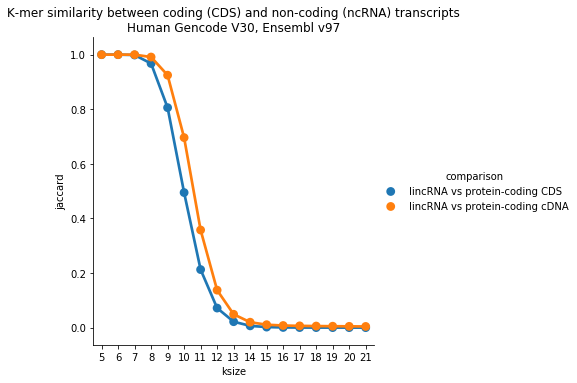

In [80]:
sns.catplot(x='ksize', y='jaccard', data=protein_coding_vs_lncrna_df, hue='comparison', kind='point')
ax = plt.gca()
ax.set(title="K-mer similarity between coding (CDS) and non-coding (ncRNA) transcripts\nHuman Gencode V30, Ensembl v97")

[Text(0.5, 1, 'K-mer similarity between lincRNA transcripts and protein-coding CDS\nHuman Gencode V30, Ensembl v97')]

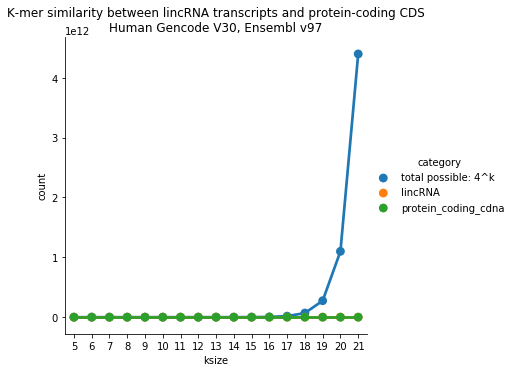

In [68]:
sns.factorplot(x='ksize', y='count', data=n_kmer_df, hue='category')
ax = plt.gca()
ax.set(title="K-mer similarity between lincRNA transcripts and protein-coding CDS\nHuman Gencode V30, Ensembl v97")

In [67]:
n_kmer_df['count_log2'] = np.log2(n_kmer_df['count'])
n_kmer_df.head()

,ksize,count,category,count_log2
0,5,1024,total possible: 4^k,10.000000
1,5,1024,lincRNA,10.000000
2,5,1024,protein_coding_cdna,10.000000
3,5,1059,protein_coding_cdna,10.048487
4,6,4096,total possible: 4^k,12.000000


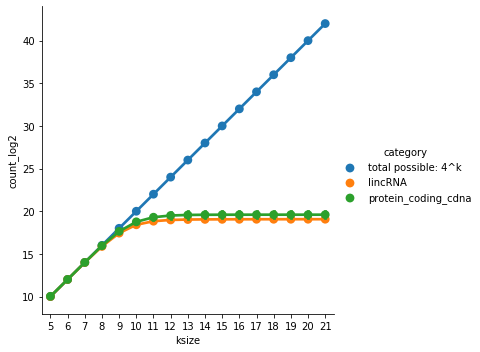

In [70]:
sns.factorplot(x='ksize', y='count_log2', data=n_kmer_df, hue='category')
ax = plt.gca()
# ax.set(title="K-mer similarity between lincRNA transcripts and protein-coding CDS\nHuman Gencode V30, Ensembl v97")

### After counting bases and kmers with rust

In [72]:
f'{4**15:,}'

'1,073,741,824'

Number of bases in human CDS

In [74]:
f'{125185305:,}'

'125,185,305'

Number of kmers in human CDS

In [78]:
f"{31877955:,}"

'31,877,955'

Number of bases in human ncRNA

In [76]:
f'{65790873:,}'

'65,790,873'

Number of kmers in human ncRNA

In [77]:
f'{28493287:,}'

'28,493,287'

In [75]:
125185305/

0.11658790055662394

In [ ]:
sns.factorplot(x='ksize', y='n_protein_coding_kmers', data=protein_coding_vs_lncrna_df)
# ax = plt.gca()
# ax.set(title="K-mer similarity between lincRNA transcripts and protein-coding CDS\nHuman Gencode V30, Ensembl v97")